In [ ]:
# 필요한 라이브러리 설치
!pip install google-cloud-bigquery pandas tensorflow numpy

# Google Cloud 인증을 위한 패키지 설치
!pip install google-colab google-auth


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.6 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import auth
from google.cloud import bigquery
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# Google Cloud 인증
auth.authenticate_user()

In [ ]:
# Google Cloud 프로젝트 ID 설정
# @markdown 프로젝트 ID를 입력하세요
project_id = "mlopstest-441106" # @param {type:"string"}
assert project_id, "프로젝트 ID를 입력해주세요!"


In [ ]:
def create_mnist_dataset():
    """MNIST 데이터를 로드하고 BigQuery 테이블용 데이터프레임으로 변환"""
    print("MNIST 데이터 로드 중...")
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # 학습 데이터 처리
    print("학습 데이터 처리 중...")
    train_data = []
    for i in range(len(x_train)):
        if i % 1000 == 0:  # 진행상황 표시
            print(f"학습 데이터 처리 중: {i}/{len(x_train)}")

        # 각 이미지를 1차원 배열로 평탄화하고 0~1 사이 값으로 정규화
        pixels = x_train[i].flatten() / 255.0
        pixels_str = ','.join(map(str, pixels))

        # 딕셔너리 형식으로 데이터 추가
        train_data.append({
            'image_id': i,
            'label': int(y_train[i]),
            'pixels': pixels_str,
            'dataset_type': 'train'
        })

    # 테스트 데이터 처리
    print("\n테스트 데이터 처리 중...")
    test_data = []
    for i in range(len(x_test)):
        if i % 1000 == 0:  # 진행상황 표시
            print(f"테스트 데이터 처리 중: {i}/{len(x_test)}")

        # 각 이미지를 1차원 배열로 평탄화하고 0~1 사이 값으로 정규화
        pixels = x_test[i].flatten() / 255.0
        pixels_str = ','.join(map(str, pixels))

        # 딕셔너리 형식으로 데이터 추가
        test_data.append({
            'image_id': i,
            'label': int(y_test[i]),
            'pixels': pixels_str,
            'dataset_type': 'test'
        })

    # DataFrame 생성
    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)
    return train_df, test_df


In [ ]:
def upload_to_bigquery(df, project_id, dataset_id, table_id):
    """데이터프레임을 BigQuery에 업로드"""
    client = bigquery.Client(project=project_id)

    print(f"데이터셋 {dataset_id} 생성 중...")
    # 데이터셋 생성 (존재하지 않는 경우)
    dataset_ref = client.dataset(dataset_id)
    try:
        client.get_dataset(dataset_ref)
    except Exception:
        dataset = bigquery.Dataset(dataset_ref)
        dataset.location = 'US'
        client.create_dataset(dataset)

    # 테이블 스키마 정의
    # 빅쿼리의 경우 테이블 스키마를 정의하고 테이블을 참고합니다.
    # 첫 스키마를 참고해서 만들어주세요!
    schema = [
        bigquery.SchemaField('image_id', 'INTEGER'),
        bigquery.SchemaField('label', 'INTEGER'),
        bigquery.SchemaField('pixels', 'STRING'),
        bigquery.SchemaField('dataset_type', 'STRING'),
    ]

    # 테이블 참조 생성
    table_ref = dataset_ref.table(table_id)
    table = bigquery.Table(table_ref, schema=schema)

    print(f"테이블 {table_id} 생성 중...")
    # 기존 테이블이 있다면 삭제
    try:
        client.delete_table(table_ref)
    except Exception:
        pass

    # 새 테이블 생성
    table = client.create_table(table)

    # 데이터 업로드
    print("데이터 업로드 중... (시간이 다소 걸릴 수 있습니다)")
    job_config = bigquery.LoadJobConfig(schema=schema)
    job = client.load_table_from_dataframe(df, table_ref, job_config=job_config)
    job.result()  # 업로드 완료 대기
    print("업로드 완료!")

In [ ]:
def visualize_mnist_sample(pixels_str, label):
    """MNIST 이미지 시각화"""
    pixels = np.array([float(x) for x in pixels_str.split(',')]).reshape(28, 28)
    plt.figure(figsize=(3, 3))
    plt.imshow(pixels, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

def query_mnist_data(project_id, dataset_id, table_id):
    """BigQuery에서 MNIST 데이터 쿼리 및 시각화"""
    client = bigquery.Client(project=project_id)

    # 1. 레이블 별 이미지 수 조회
    print("\n레이블 별 이미지 수 분석 중...")
    # 각 label 값이 몇 번 등장하는지 세고 label 기준으로 정렬하는 집계 쿼리
    count_query = f"""
        SELECT label, COUNT(*) as count
        FROM `{project_id}.{dataset_id}.{table_id}`
        GROUP BY label
        ORDER BY label
    """
    counts_df = client.query(count_query).to_dataframe()

    # 레이블 분포 시각화
    plt.figure(figsize=(10, 5))
    plt.bar(counts_df['label'], counts_df['count'])
    plt.title('Number of Images per Label')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

    # 2. 각 레이블의 샘플 이미지 조회
    print("\n각 레이블의 샘플 이미지 조회 중...")
    sample_query = f"""
        SELECT t1.*
        FROM `{project_id}.{dataset_id}.{table_id}` t1
        INNER JOIN (
            SELECT label, MIN(image_id) as min_id
            FROM `{project_id}.{dataset_id}.{table_id}`
            WHERE dataset_type = 'train'
            GROUP BY label
        ) t2
        ON t1.label = t2.label AND t1.image_id = t2.min_id
        ORDER BY t1.label
    """
    samples_df = client.query(sample_query).to_dataframe()

    # 샘플 이미지 시각화
    for _, row in samples_df.iterrows():
        visualize_mnist_sample(row['pixels'], row['label'])


MNIST 데이터 로드 중...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
학습 데이터 처리 중...
학습 데이터 처리 중: 0/60000
학습 데이터 처리 중: 1000/60000
학습 데이터 처리 중: 2000/60000
학습 데이터 처리 중: 3000/60000
학습 데이터 처리 중: 4000/60000
학습 데이터 처리 중: 5000/60000
학습 데이터 처리 중: 6000/60000
학습 데이터 처리 중: 7000/60000
학습 데이터 처리 중: 8000/60000
학습 데이터 처리 중: 9000/60000
학습 데이터 처리 중: 10000/60000
학습 데이터 처리 중: 11000/60000
학습 데이터 처리 중: 12000/60000
학습 데이터 처리 중: 13000/60000
학습 데이터 처리 중: 14000/60000
학습 데이터 처리 중: 15000/60000
학습 데이터 처리 중: 16000/60000
학습 데이터 처리 중: 17000/60000
학습 데이터 처리 중: 18000/60000
학습 데이터 처리 중: 19000/60000
학습 데이터 처리 중: 20000/60000
학습 데이터 처리 중: 21000/60000
학습 데이터 처리 중: 22000/60000
학습 데이터 처리 중: 23000/60000
학습 데이터 처리 중: 24000/60000
학습 데이터 처리 중: 25000/60000
학습 데이터 처리 중: 26000/60000
학습 데이터 처리 중: 27000/60000
학습 데이터 처리 중: 28000/60000
학습 데이터 처리 중: 29000/60000
학습 데이터 처리 중: 30000/60000
학습 데이터 처리 중: 31000/60000
학습 데이터 처리 중: 32000/60000
학습 데이터 처리 중: 33000/60000
학습 데이터 처리 중: 34000/60000
학습 데이터 처리 중: 35000/60000
학습 데이터 처리 중: 36000/60000
학습 데

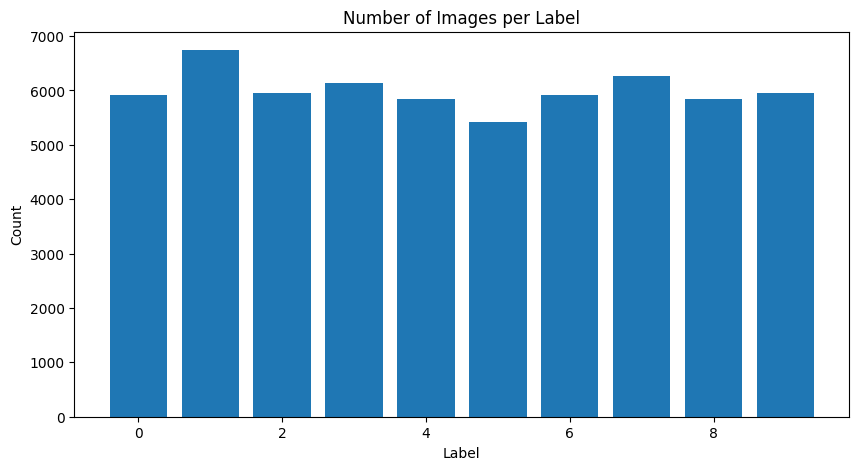


각 레이블의 샘플 이미지 조회 중...


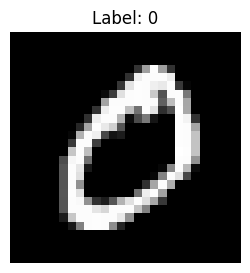

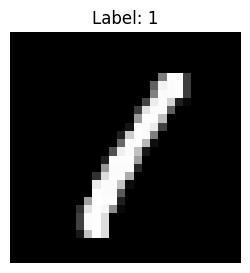

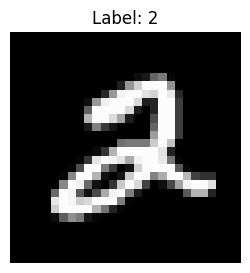

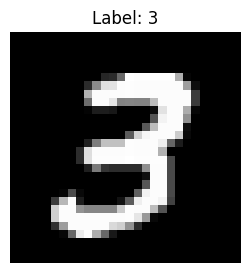

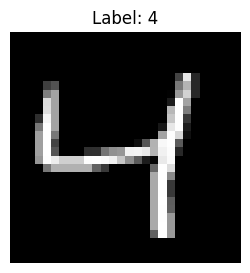

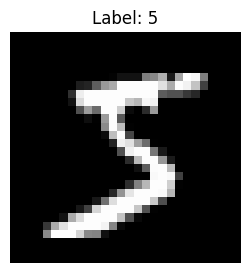

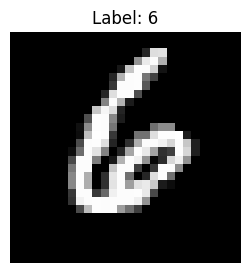

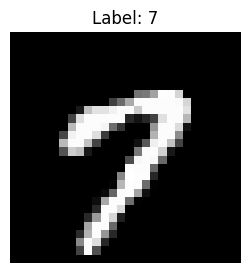

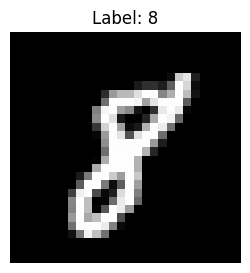

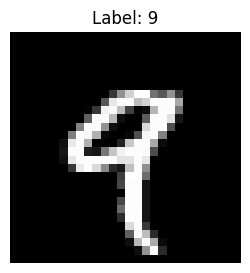


레이블 별 이미지 수 분석 중...


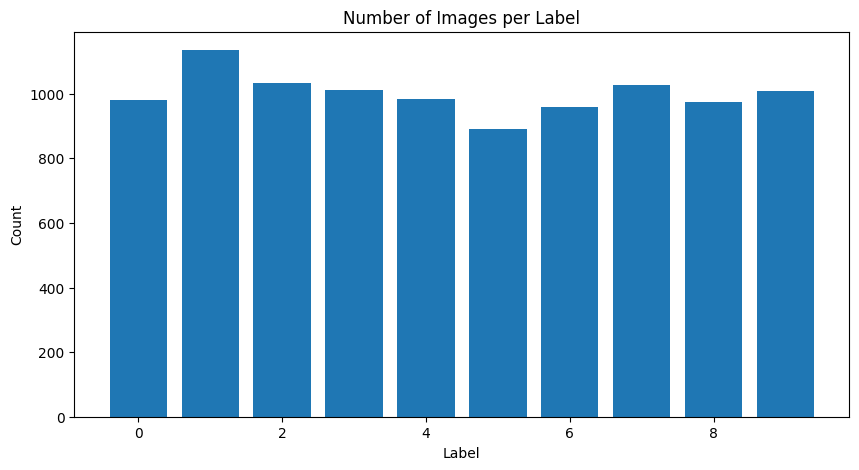


각 레이블의 샘플 이미지 조회 중...


In [ ]:
dataset_id = 'mnist_dataset'
table_train_id = 'mnist_train_images'
table_test_id = 'mnist_test_images'

# MNIST 데이터 준비
train_df, test_df = create_mnist_dataset()

# BigQuery에 업로드
upload_to_bigquery(train_df, project_id, dataset_id, table_train_id)
upload_to_bigquery(test_df, project_id, dataset_id, table_test_id)

# 데이터 분석 및 시각화
query_mnist_data(project_id, dataset_id, table_train_id)
query_mnist_data(project_id, dataset_id, table_test_id)

구글 클라우드 콘솔에 접속한 뒤 `mnist_train_images`, `mnist_test_images` 테이블이 나오면 성공입니다! \\
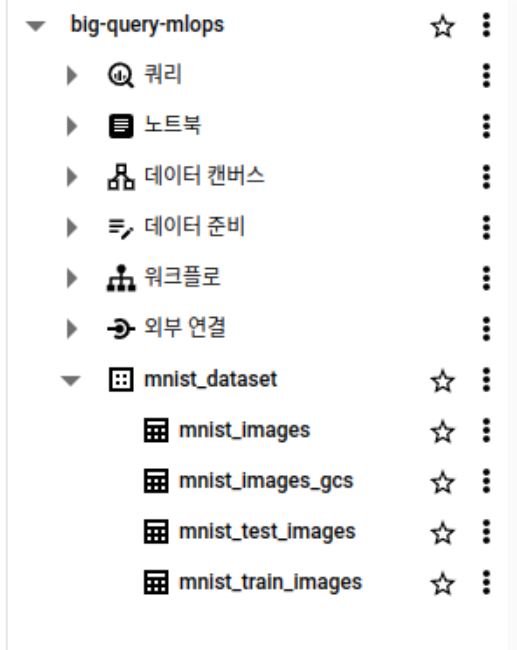